# Notebook 03: Classification Model

**Student Name:** clifton rand

**Dataset:** Exam_Score_Prediction.csv

**Original Target Variable:** exam_score

**Binned Target Variable:** low/medium/high

**Checkpoint 4 Due:** Feb 22

---

## Rules & Integrity

1. **NO AI TOOLS**: You may **NOT** use ChatGPT, Claude, Gemini, GitHub Copilot, or any other AI assistant to generate code for this assignment. The goal is to build *your* fundamental skills. If you rely on AI now, the advanced topics later will be impossible.

2. **Study Groups Encouraged**: You **ARE** encouraged to discuss ideas, share approaches, and explain concepts to your study group peers. Teaching others is the best way to learn! However, the code you submit must be **your own work**.

3. **Use Your Resources**: You are free to use Google, StackOverflow, Pandas/Scikit-learn documentation, and your class notes.

4. **Comment Your Code**: Include comments explaining *why* you're doing what you're doing. I want to see your thought process.

5. **Resubmission**: You may submit this assignment multiple times for feedback before the checkpoint deadline.

---

## Important: Written Reflections

Throughout this notebook, you'll be asked to interpret results, justify decisions, and explain your reasoning. **These written reflections are a critical part of your grade.**

Your binning justification, model selection reasoning, and analysis of the confusion matrix demonstrate your understanding. These reflections are what employers look for—the ability to communicate technical decisions clearly.

---

## Setup

In [58]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn - preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Sklearn - models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Sklearn - evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, ConfusionMatrixDisplay
)

# Model saving
import joblib

# Settings
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

print("Libraries imported successfully!")

Libraries imported successfully!


## Section 1: Load Processed Data

In [59]:
# Load cleaned data
df = pd.read_csv('../data/processed/cleaned_data.csv')

print(f"Data shape: {df.shape}")
df.head()

Data shape: (20000, 9)


,age,study_hours,class_attendance,sleep_hours,exam_score,sleep_quality_good,sleep_quality_poor,exam_difficulty_hard,exam_difficulty_moderate
0,17,2.78,92.9,7.4,58.9,False,True,True,False
1,23,3.37,64.8,4.6,54.8,False,False,False,True
2,22,7.88,76.8,8.5,90.3,False,True,False,True
3,20,0.67,48.4,5.8,29.7,False,False,False,True
4,20,0.89,71.6,9.8,43.7,False,True,False,True


In [60]:
# Define your original target variable
ORIGINAL_TARGET = 'exam_score'  # <-- UPDATE THIS

print(f"Original Target: {ORIGINAL_TARGET}")
print(f"\nTarget statistics:")
print(df[ORIGINAL_TARGET].describe())

Original Target: exam_score

Target statistics:
count    20000.000000
mean        62.513225
std         18.908491
min         19.599000
25%         48.800000
50%         62.600000
75%         76.300000
max        100.000000
Name: exam_score, dtype: float64


## Section 2: Create Binned Target

Convert your regression target into classification categories.

### 2.1 Binning Strategy Justification

**Your approved binning strategy:**

- **Number of categories:** [e.g., 3]
- **Category names:** [e.g., Low, Medium, High]
- **Thresholds:** [e.g., Low: < $50,000, Medium: $50,000-$100,000, High: > $100,000]

**Why this makes sense for your problem:**

i chose 3 because it makes sense to group the scores into low, medium, and high

In [61]:
# View the distribution before binning
print("Target distribution:")
print(f"Min: {df[ORIGINAL_TARGET].min():.2f}")
print(f"25th percentile: {df[ORIGINAL_TARGET].quantile(0.25):.2f}")
print(f"Median: {df[ORIGINAL_TARGET].median():.2f}")
print(f"75th percentile: {df[ORIGINAL_TARGET].quantile(0.75):.2f}")
print(f"Max: {df[ORIGINAL_TARGET].max():.2f}")

Target distribution:
Min: 19.60
25th percentile: 48.80
Median: 62.60
75th percentile: 76.30
Max: 100.00


In [62]:
# TODO: Create your binned target using YOUR approved binning strategy
#
# Steps:
# 1. Define your bin edges (e.g., bins = [min-1, threshold1, threshold2, max+1])
# 2. Define your category labels (e.g., labels = ['Low', 'Medium', 'High'])
# 3. Use pd.cut() to create the binned column
#
# Example:
# bins = [df[ORIGINAL_TARGET].min()-1, 50000, 100000, df[ORIGINAL_TARGET].max()+1]
# labels = ['Low', 'Medium', 'High']
# df['target_category'] = pd.cut(df[ORIGINAL_TARGET], bins=bins, labels=labels)

# YOUR CODE HERE:
bins = [df['exam_score'].min()-1, df['exam_score'].quantile(0.33), df['exam_score'].quantile(0.66), df['exam_score'].max()+1]  # Define your bin edges
labels = ['low', 'medium', 'high']  # Define your category names

df['exam_score'] = pd.cut(df[ORIGINAL_TARGET], bins=bins, labels=labels)

print("Binned target distribution:")
print(df['exam_score'].value_counts())

Binned target distribution:
exam_score
high      6787
low       6619
medium    6594
Name: count, dtype: int64


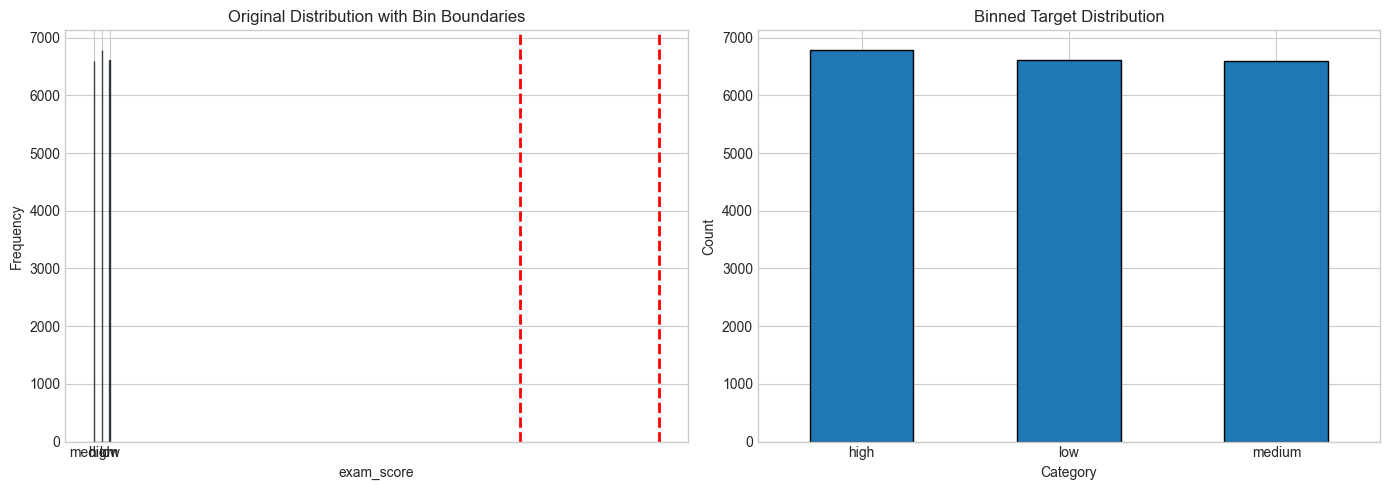

In [63]:
# Visualize the binned distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original distribution with bin lines
axes[0].hist(df[ORIGINAL_TARGET], bins=30, edgecolor='black', alpha=0.7)
for edge in bins[1:-1]:  # Skip first and last (min/max)
    axes[0].axvline(edge, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel(ORIGINAL_TARGET)
axes[0].set_ylabel('Frequency')
axes[0].set_title('Original Distribution with Bin Boundaries')

# Binned category counts
df['exam_score'].value_counts().plot(kind='bar', ax=axes[1], edgecolor='black')
axes[1].set_xlabel('Category')
axes[1].set_ylabel('Count')
axes[1].set_title('Binned Target Distribution')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

### 2.2 Check Class Balance

*Is your binned target reasonably balanced?*

In [64]:
# Check class balance
class_counts = df['exam_score'].value_counts()
class_percentages = df['exam_score'].value_counts(normalize=True) * 100

print("Class Distribution:")
for cat in class_counts.index:
    print(f"{cat}: {class_counts[cat]} ({class_percentages[cat]:.1f}%)")

# Check for severe imbalance
min_class_pct = class_percentages.min()
if min_class_pct < 10:
    print(f"\nWarning: Smallest class is only {min_class_pct:.1f}% of data.")
    print("Consider adjusting your binning strategy.")
else:
    print(f"\nClass balance looks reasonable!")

Class Distribution:
high: 6787 (33.9%)
low: 6619 (33.1%)
medium: 6594 (33.0%)

Class balance looks reasonable!


## Section 3: Feature Consistency Check

**Important:** For consistency, you should use the same features for classification as you did for regression. This makes your app simpler (users enter the same inputs for both models) and allows for fair comparison.

If you decide to use different features, provide a strong justification below.

In [65]:
# Load the features you selected in the regression notebook
try:
    regression_features = joblib.load('../models/regression_features.pkl')
    print("Features from Regression Model:")
    print(regression_features)
    print(f"\nNumber of regression features: {len(regression_features)}")
except FileNotFoundError:
    print("Warning: regression_features.pkl not found!")
    print("Make sure you've completed Notebook 02 and saved your regression model first.")
    regression_features = None

Features from Regression Model:
['study_hours', 'class_attendance', 'sleep_quality_poor', 'sleep_quality_good', 'sleep_hours']

Number of regression features: 5


### Feature Selection Decision

**Will you use the same features as your regression model?**

- [ ] **Yes, same features** (Recommended for simpler deployment)
- [ ] **No, different features** (Requires justification below)

**If using different features, justify why:**

[Write your justification here - e.g., "For classification, feature X is less predictive of categories than it was for the continuous target..."]

In [66]:
# DECIDE: Use regression features or define new ones?

# Option A: Use the same features as regression (RECOMMENDED)
if regression_features is not None:
    SELECTED_FEATURES = regression_features
    print("Using same features as regression model.")
else:
    # Option B: Define your own features (if regression not done yet)
    SELECTED_FEATURES = [
        # 'feature1',
        # 'feature2',
        # 'feature3',
        # etc.
    ]
    print("Defining features manually.")

print(f"\nSelected features for classification ({len(SELECTED_FEATURES)}):")
for i, f in enumerate(SELECTED_FEATURES, 1):
    print(f"  {i}. {f}")

Using same features as regression model.

Selected features for classification (5):
  1. study_hours
  2. class_attendance
  3. sleep_quality_poor
  4. sleep_quality_good
  5. sleep_hours


## Section 4: Prepare Features and Target

In [67]:
# Create feature matrix using SELECTED features
X = df[SELECTED_FEATURES].copy()
y = df['exam_score']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures used: {X.columns.tolist()}")
print(f"\nTarget classes: {y.unique().tolist()}")

Features shape: (20000, 5)
Target shape: (20000,)

Features used: ['study_hours', 'class_attendance', 'sleep_quality_poor', 'sleep_quality_good', 'sleep_hours']

Target classes: ['medium', 'high', 'low']


### 4.1 Label Encoding

Many sklearn models require numeric targets. Use LabelEncoder to convert category names to numbers.

In [68]:
# TODO: Encode your target labels to numbers using LabelEncoder
#
# Steps:
# 1. Create a LabelEncoder instance
# 2. Fit and transform y to create y_encoded
#
# Hint: label_encoder.fit_transform(y)

# YOUR CODE HERE:
label_encoder = LabelEncoder()

# 2. Fit and transform target
y_encoded = label_encoder.fit_transform(y)


In [69]:
# Verify encoding (run this to check)
print("Label encoding:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label} -> {i}")

Label encoding:
high -> 0
low -> 1
medium -> 2


## Section 5: Train-Test Split

For classification, we use **stratified** splitting to ensure each class is proportionally represented in both train and test sets.

In [70]:
# TODO: Split your data with stratification
#
# Requirements:
# - 80/20 split (test_size=0.2)
# - random_state=42 for reproducibility
# - stratify=y_encoded (THIS IS THE KEY DIFFERENCE FROM REGRESSION!)
#   This ensures each class is proportionally represented in train/test
#
# Store in: X_train, X_test, y_train, y_test

# YOUR CODE HERE:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)


In [71]:
# Verify split and stratification
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

print(f"\nTraining class distribution:")
unique, counts = np.unique(y_train, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  {label_encoder.classes_[u]}: {c} ({c/len(y_train)*100:.1f}%)")

Training set: 16000 samples
Test set: 4000 samples

Training class distribution:
  high: 5430 (33.9%)
  low: 5295 (33.1%)
  medium: 5275 (33.0%)


## Section 6: Feature Scaling

In [72]:
# TODO: Scale your features using StandardScaler
#
# Same as regression:
# 1. Create StandardScaler instance
# 2. fit_transform on X_train
# 3. transform (only!) on X_test
#
# Store in: X_train_scaled, X_test_scaled

# YOUR CODE HERE:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)


In [73]:
# Convert to DataFrame (helpful for later)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Features scaled successfully!")
print(f"Scaler fitted on {len(SELECTED_FEATURES)} features.")

Features scaled successfully!
Scaler fitted on 5 features.


## Section 7: Baseline Model

In [74]:
# This helper function evaluates any classifier - you'll use it throughout
def evaluate_classifier(model, X_train, X_test, y_train, y_test, model_name):
    """Train classifier and return evaluation metrics."""
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    results = {
        'Model': model_name,
        'Train Accuracy': accuracy_score(y_train, y_train_pred),
        'Test Accuracy': accuracy_score(y_test, y_test_pred),
        'Precision (weighted)': precision_score(y_test, y_test_pred, average='weighted'),
        'Recall (weighted)': recall_score(y_test, y_test_pred, average='weighted'),
        'F1 (weighted)': f1_score(y_test, y_test_pred, average='weighted')
    }
    
    return results, model, y_test_pred

In [75]:
# TODO: Create and evaluate a baseline Logistic Regression model
#
# Create LogisticRegression(random_state=42, max_iter=1000)
# Use evaluate_classifier() to train and evaluate

# YOUR CODE HERE:
# baseline_model = ...
# baseline_results, baseline_trained, baseline_preds = evaluate_classifier(...)

baseline_model = LogisticRegression(
    random_state=42,
    max_iter=1000
)

baseline_results, baseline_trained, baseline_preds = evaluate_classifier(
    baseline_model,
    X_train_scaled,
    X_test_scaled,
    y_train,
    y_test,
    "Logistic Regression (Baseline)"
)


In [76]:
# Display baseline results
print("=" * 50)
print("BASELINE MODEL: Logistic Regression")
print("=" * 50)
print(f"Train Accuracy: {baseline_results['Train Accuracy']:.4f}")
print(f"Test Accuracy:  {baseline_results['Test Accuracy']:.4f}")
print(f"F1 Score:       {baseline_results['F1 (weighted)']:.4f}")

BASELINE MODEL: Logistic Regression
Train Accuracy: 0.6764
Test Accuracy:  0.6783
F1 Score:       0.6751


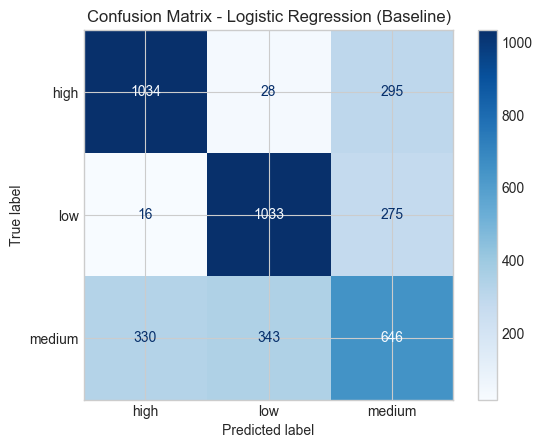

In [77]:
# TODO: Create and display the confusion matrix for baseline
#
# Steps:
# 1. Use confusion_matrix(y_test, baseline_preds) to create the matrix
# 2. Use ConfusionMatrixDisplay to visualize it
#
# Hint: ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

# YOUR CODE HERE:
cm = confusion_matrix(y_test, baseline_preds)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=label_encoder.classes_
)

disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression (Baseline)")
plt.show()


### Understanding the Confusion Matrix

The confusion matrix shows where your model gets predictions right and wrong:

- **Diagonal cells (top-left to bottom-right):** Correct predictions
- **Off-diagonal cells:** Misclassifications
- **Row:** What the actual class was
- **Column:** What the model predicted

**How to read it:** 
- If a row has many values spread across columns, that class is often confused with others
- If a column has many values from different rows, the model is predicting that class too often

**Example interpretation:**
- "20 Low samples were correctly predicted as Low"
- "5 Medium samples were incorrectly predicted as High"

### Baseline Interpretation

*Analyze your baseline results:*

**Questions to answer:**
- How well does the baseline perform? pretty well
- Which classes are easiest/hardest to predict (look at the diagonal)? low and high scores
- Where does the model get confused (look at off-diagonal cells)? medium scores
- Is there overfitting (train vs test accuracy gap)? no

**Your interpretation:**

- How well does the baseline perform? pretty well
- Which classes are easiest/hardest to predict (look at the diagonal)? low and high scores
- Where does the model get confused (look at off-diagonal cells)? medium scores
- Is there overfitting (train vs test accuracy gap)? no

## Section 8: Cross-Validation

Cross-validation gives us a more robust estimate of model performance by training on different portions of the data.

In [78]:
# Cross-validation for key models
print("5-Fold Cross-Validation Results")
print("=" * 50)

models_to_cv = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42)
}

cv_results = []
for name, model in models_to_cv.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    cv_results.append({
        'Model': name,
        'CV Mean Accuracy': scores.mean(),
        'CV Std': scores.std()
    })
    print(f"{name}: {scores.mean():.4f} (+/- {scores.std()*2:.4f})")

cv_df = pd.DataFrame(cv_results)
cv_df

5-Fold Cross-Validation Results
Logistic Regression: 0.6764 (+/- 0.0122)
Random Forest: 0.6647 (+/- 0.0044)
Gradient Boosting: 0.6643 (+/- 0.0096)


,Model,CV Mean Accuracy,CV Std
0,Logistic Regression,0.676375,0.006119
1,Random Forest,0.664687,0.002210
2,Gradient Boosting,0.664250,0.004815


### Cross-Validation Interpretation

*What does the cross-validation tell you?*

- Which model is most consistent (lowest std)?
- Does the ranking change from the single train/test split?

**Your interpretation:**

The random forest is the most consistent and the ranking doesnt change

## Section 9: Model Iteration

In [79]:
# Store all results
all_results = [baseline_results]

# Dictionary to store trained models
trained_models = {
    'Logistic Regression (Baseline)': baseline_trained
}

### Model 2: Decision Tree

In [80]:
# TODO: Create and evaluate a Decision Tree classifier
#
# Create DecisionTreeClassifier(max_depth=10, random_state=42)
# Use evaluate_classifier() to train and evaluate
# Add results to all_results and trained_models

# YOUR CODE HERE:
dt = DecisionTreeClassifier(
    max_depth=10,
    random_state=42
)

dt_results, dt_trained, dt_preds = evaluate_classifier(
    dt,
    X_train,
    X_test,
    y_train,
    y_test,
    "Decision Tree (max_depth=10)"
)

all_results.append(dt_results)
trained_models["Decision Tree (max_depth=10)"] = dt_trained

# Print results
print(f"Decision Tree - Test Accuracy: {dt_results['Test Accuracy']:.4f}, F1: {dt_results['F1 (weighted)']:.4f}")

Decision Tree - Test Accuracy: 0.6385, F1: 0.6368


### Model 3: Random Forest

In [81]:
# TODO: Create and evaluate a Random Forest classifier
#
# Create RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
# Use evaluate_classifier()
# Add to all_results and trained_models

# YOUR CODE HERE:
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42
)

rf_results, rf_trained, rf_preds = evaluate_classifier(
    rf,
    X_train,
    X_test,
    y_train,
    y_test,
    "Random Forest (100 trees, max_depth=10)"
)

all_results.append(rf_results)
trained_models["Random Forest (100 trees, max_depth=10)"] = rf_trained

# Print results
print(f"Random Forest - Test Accuracy: {rf_results['Test Accuracy']:.4f}, F1: {rf_results['F1 (weighted)']:.4f}")

Random Forest - Test Accuracy: 0.6630, F1: 0.6615


### Model 4: K-Nearest Neighbors

In [82]:
# TODO: Create and evaluate a KNN classifier
#
# Create KNeighborsClassifier(n_neighbors=5)
# Use evaluate_classifier()
# Add to all_results and trained_models

# YOUR CODE HERE:
knn = KNeighborsClassifier(n_neighbors=5)

knn_results, knn_trained, knn_preds = evaluate_classifier(
    knn,
    X_train_scaled,
    X_test_scaled,
    y_train,
    y_test,
    "KNN (k=5)"
)

all_results.append(knn_results)
trained_models["KNN (k=5)"] = knn_trained

# Print results
print(f"KNN - Test Accuracy: {knn_results['Test Accuracy']:.4f}, F1: {knn_results['F1 (weighted)']:.4f}")

KNN - Test Accuracy: 0.6355, F1: 0.6274


### Model 5: Gradient Boosting

In [83]:
# TODO: Create and evaluate a Gradient Boosting classifier
#
# Create GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42)
# Use evaluate_classifier()
# Add to all_results and trained_models

# YOUR CODE HERE:
gb = GradientBoostingClassifier(
    n_estimators=100, 
    max_depth=5, 
    random_state=42
)

gb_results, gb_trained, gb_preds = evaluate_classifier(
    gb,
    X_train,
    X_test,
    y_train,
    y_test,
    "Gradient Boosting (n_estimators=100)"
)

all_results.append(gb_results)
trained_models["Gradient Boosting (n_estimators=100)"] = gb_trained

# Print results
print(f"Gradient Boosting - Test Accuracy: {gb_results['Test Accuracy']:.4f}, F1: {gb_results['F1 (weighted)']:.4f}")

Gradient Boosting - Test Accuracy: 0.6575, F1: 0.6564


### Add Your Own Model (Optional)

Try a different model or different hyperparameters!

In [84]:
# YOUR ADDITIONAL MODEL HERE:
# Try SVC, different hyperparameters, or another classifier

svc = SVC(kernel='rbf', random_state=42)

svm_results, svm_trained, svm_preds = evaluate_classifier(
    svc,
    X_train_scaled,
    X_test_scaled,
    y_train,
    y_test,
    "SVM (RBF Kernel)"
)

all_results.append(svm_results)
trained_models["SVM (RBF Kernel)"] = svm_trained

## Section 10: Model Comparison

In [85]:
# Create comparison DataFrame
results_df = pd.DataFrame(all_results)
results_df = results_df.round(4)
results_df = results_df.sort_values('Test Accuracy', ascending=False)

print("Model Comparison:")
results_df

Model Comparison:


,Model,Train Accuracy,Test Accuracy,Precision (weighted),Recall (weighted),F1 (weighted)
0,Logistic Regression (Baseline),0.6764,0.6782,0.6729,0.6782,0.6751
5,SVM (RBF Kernel),0.6800,0.6778,0.6747,0.6778,0.6757
2,"Random Forest (100 trees, max_depth=10)",0.7618,0.6630,0.6605,0.6630,0.6615
4,Gradient Boosting (n_estimators=100),0.7318,0.6575,0.6557,0.6575,0.6564
1,Decision Tree (max_depth=10),0.7392,0.6385,0.6355,0.6385,0.6368
3,KNN (k=5),0.7378,0.6355,0.6238,0.6355,0.6274


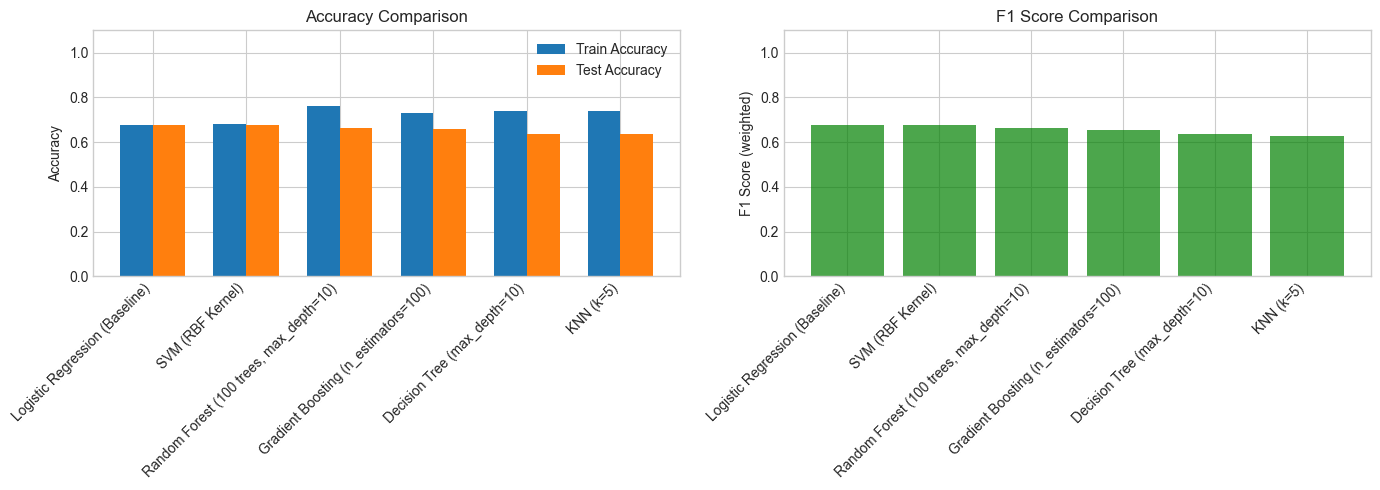

In [86]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

models = results_df['Model']
x = np.arange(len(models))
width = 0.35

# Accuracy comparison
axes[0].bar(x - width/2, results_df['Train Accuracy'], width, label='Train Accuracy')
axes[0].bar(x + width/2, results_df['Test Accuracy'], width, label='Test Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models, rotation=45, ha='right')
axes[0].legend()
axes[0].set_ylim(0, 1.1)

# F1 Score comparison
axes[1].bar(x, results_df['F1 (weighted)'], color='green', alpha=0.7)
axes[1].set_ylabel('F1 Score (weighted)')
axes[1].set_title('F1 Score Comparison')
axes[1].set_xticks(x)
axes[1].set_xticklabels(models, rotation=45, ha='right')
axes[1].set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

## Section 11: Best Model Selection

In [87]:
# Identify best model (by test accuracy)
best_model_name = results_df.iloc[0]['Model']
best_model = trained_models[best_model_name]

print(f"Best Model: {best_model_name}")
print(f"Test Accuracy: {results_df.iloc[0]['Test Accuracy']:.4f}")
print(f"F1 Score: {results_df.iloc[0]['F1 (weighted)']:.4f}")

Best Model: Logistic Regression (Baseline)
Test Accuracy: 0.6782
F1 Score: 0.6751


### Best Model Justification

*Explain why you chose this model:*

**Questions to consider:**
- Why this model over others?it has the highest combination of both train and test scores
- Is there significant overfitting? no
- How does it compare to baseline? it is the baseline
- Which metrics did you prioritize and why? i prioritized f1 score and a test/train accuracy

**Your justification:**

- Why this model over others?it has the highest combination of both train and test scores
- Is there significant overfitting? no
- How does it compare to baseline? it is the baseline
- Which metrics did you prioritize and why? i prioritized f1 score and a test/train accuracy

## Section 12: Best Model Analysis

In [88]:
# Get predictions from best model
y_pred = best_model.predict(X_test_scaled)

# Detailed classification report
print("Classification Report:")
print("=" * 50)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Classification Report:
              precision    recall  f1-score   support

        high       0.75      0.76      0.76      1357
         low       0.74      0.78      0.76      1324
      medium       0.53      0.49      0.51      1319

    accuracy                           0.68      4000
   macro avg       0.67      0.68      0.67      4000
weighted avg       0.67      0.68      0.68      4000



### Understanding the Classification Report

The classification report shows per-class metrics:

- **Precision:** Of all predictions for this class, what % were correct?
  - High precision = Few false positives
  - Example: "When the model predicts 'High', it's correct 85% of the time"

- **Recall:** Of all actual instances of this class, what % did we find?
  - High recall = Few false negatives
  - Example: "We correctly identified 90% of all actual 'High' cases"

- **F1-Score:** Harmonic mean of precision and recall (balanced measure)
  - Good when you need both precision and recall

- **Support:** Number of actual occurrences of each class in the test set

<Figure size 800x600 with 0 Axes>

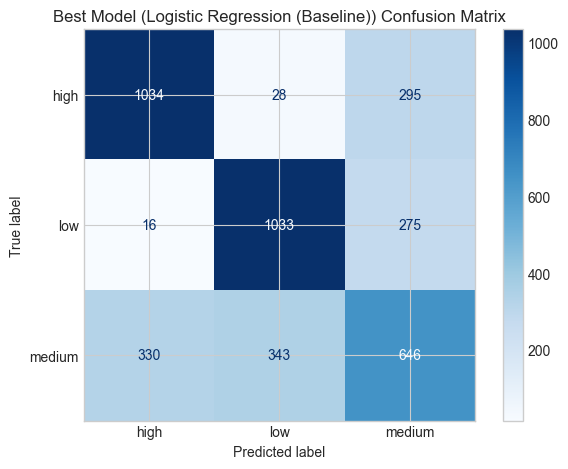

In [89]:
# Confusion matrix for best model
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues')
plt.title(f'Best Model ({best_model_name}) Confusion Matrix')
plt.tight_layout()
plt.show()

### Detailed Confusion Matrix Analysis

*Analyze the confusion matrix carefully:*

**For each class, describe:**
1. How many correct predictions (diagonal)?
2. What are the most common misclassifications?
3. Does the confusion make sense for your problem?

**Your analysis:**

there were over a thousand correct predictions for high and low, and only 650 for medium.  It does make sense because there is a human element of skill that isnt represented in the data that could make the study hours not precisely line up with exam score.

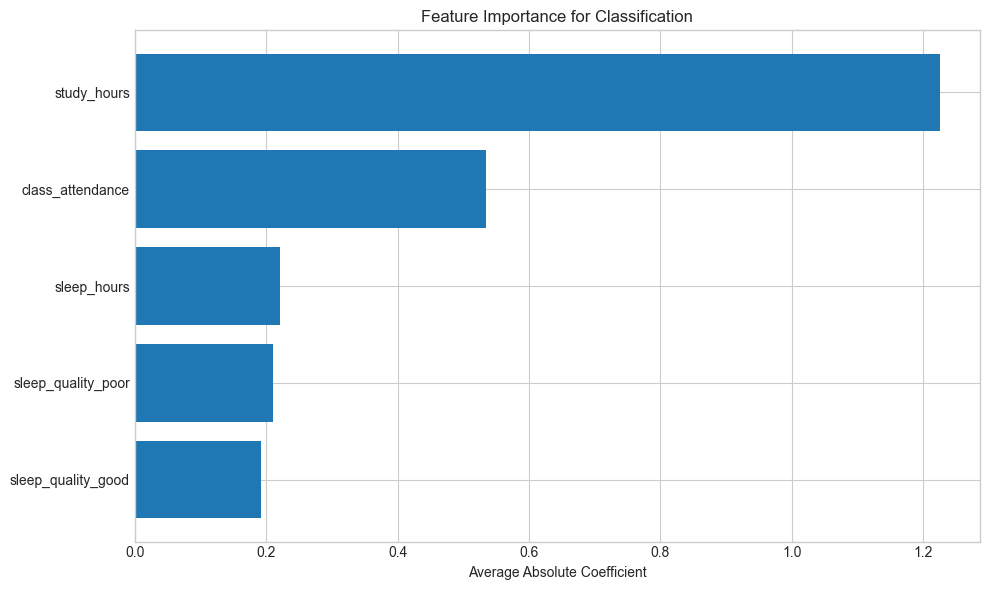

In [90]:
# Feature importance (if available)
if hasattr(best_model, 'feature_importances_'):
    importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=True)
    
    plt.figure(figsize=(10, 6))
    plt.barh(importance['Feature'], importance['Importance'])
    plt.xlabel('Importance')
    plt.title('Feature Importance for Classification')
    plt.tight_layout()
    plt.show()
    
    print("\nTop 5 most important features:")
    for i, row in importance.tail(5).iloc[::-1].iterrows():
        print(f"  {row['Feature']}: {row['Importance']:.4f}")
        
elif hasattr(best_model, 'coef_'):
    # For multi-class, coef_ has shape (n_classes, n_features)
    coef = best_model.coef_
    if len(coef.shape) > 1:
        # Average absolute importance across classes
        importance_vals = np.abs(coef).mean(axis=0)
    else:
        importance_vals = np.abs(coef)
    
    importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importance_vals
    }).sort_values('Importance', ascending=True)
    
    plt.figure(figsize=(10, 6))
    plt.barh(importance['Feature'], importance['Importance'])
    plt.xlabel('Average Absolute Coefficient')
    plt.title('Feature Importance for Classification')
    plt.tight_layout()
    plt.show()

## Section 13: Model Iteration Reflection

*Reflect on your modeling process:*

**1. How did your models evolve from baseline to best?**

It did not because nothing outpreformed the baseline

**2. What surprised you about the results?**

that the baseline ended up being the best choice, i would have thought any other model would perform better

**3. If you had more time, what would you try next?**

i would try xgboost

## Section 14: Save Model and Artifacts

In [91]:
# Save the best classification model
model_path = '../models/classification_model.pkl'
joblib.dump(best_model, model_path)
print(f"Model saved to {model_path}")

# Save the scaler (fitted on SELECTED features)
scaler_path = '../models/classification_scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to {scaler_path}")

# Save the label encoder
encoder_path = '../models/label_encoder.pkl'
joblib.dump(label_encoder, encoder_path)
print(f"Label encoder saved to {encoder_path}")

# Save feature names (SELECTED_FEATURES)
features_path = '../models/classification_features.pkl'
joblib.dump(SELECTED_FEATURES, features_path)
print(f"Features saved to {features_path}")

# Save binning info (for reference in Streamlit app)
binning_info = {
    'bins': bins,
    'labels': labels,
    'original_target': ORIGINAL_TARGET
}
binning_path = '../models/binning_info.pkl'
joblib.dump(binning_info, binning_path)
print(f"Binning info saved to {binning_path}")

Model saved to ../models/classification_model.pkl
Scaler saved to ../models/classification_scaler.pkl
Label encoder saved to ../models/label_encoder.pkl
Features saved to ../models/classification_features.pkl
Binning info saved to ../models/binning_info.pkl


In [92]:
# Verify saved model works
loaded_model = joblib.load(model_path)
loaded_scaler = joblib.load(scaler_path)
loaded_encoder = joblib.load(encoder_path)

# Test prediction
test_sample = X_test.iloc[[0]]
test_sample_scaled = loaded_scaler.transform(test_sample)
test_pred = loaded_model.predict(test_sample_scaled)
test_pred_label = loaded_encoder.inverse_transform(test_pred)

print(f"\nModel verification:")
print(f"Sample input: {test_sample.values[0][:3]}...")
print(f"Predicted class: {test_pred_label[0]}")
print(f"Actual class: {loaded_encoder.inverse_transform([y_test[0]])[0]}")
print("\nModel saved and verified successfully!")


Model verification:
Sample input: [2.19 86.8 True]...
Predicted class: low
Actual class: low

Model saved and verified successfully!


---

## Summary

### What You Accomplished
- [ ] Created binned target variable with justification
- [ ] Verified class balance
- [ ] Used consistent features (same as regression or justified different)
- [ ] Split data with stratification
- [ ] Performed cross-validation
- [ ] Built baseline classifier
- [ ] Tried multiple classifier types
- [ ] Compared and selected best model
- [ ] Analyzed model with confusion matrix and classification report
- [ ] Saved model, scaler, encoder, and binning info

### Key Results

**Best Model:** baseline

**Test Accuracy:** .6782

**F1 Score:** .6751

**Improvement over baseline:** none

### Comparison to Regression

*How does classification performance relate to your regression results?*

[Write your comparison here - consider: the classification and regression results were the same

---

## Next Steps

Move on to building your **Streamlit app** to deploy both models!

You now have saved:
- `regression_model.pkl` and `regression_scaler.pkl`
- `classification_model.pkl`, `classification_scaler.pkl`, and `label_encoder.pkl`

The Streamlit starter code in `app/app.py` will load these files.

---

## Checkpoint 4 Submission Instructions

You've completed the classification model. Time to submit!

### Step 1: Save and Close
Make sure this notebook is saved and all cells have been run.

### Step 2: Commit Your Work
```bash
git add .
git commit -m "Complete classification model - Checkpoint 4"
git push
```

### Step 3: Submit to Canvas
1. Go to Canvas
2. Find the **Checkpoint 4: Classification Model** assignment
3. Submit the link to your GitHub repository

### What Gets Graded
- Binning justification and implementation
- Feature consistency (same as regression or justified different)
- Model comparison and selection reasoning
- Confusion matrix interpretation
- Classification report analysis
- All written reflections completed

---